### Local differential privacy

All values are in {-1, 1} representation.

Here is our underlying implementation of randomized response.  In the {-1,1} representation, we can flip the response by multiplying by -1.

In [2]:
import numpy as np


def local_release(x, epsilon):
    x = np.array(x)

    draw = np.random.uniform(size=x.shape)
    cutoff =   #Fix This
    x *= -1    #Fix This

    return x


SyntaxError: invalid syntax (<ipython-input-2-2b1327313c2d>, line 8)

#### Show RR flip probability

epsilon sequence [10.    7.5   5.62  4.22  3.16  2.37  1.78  1.33  1.    0.75  0.56  0.42
  0.32  0.24  0.18  0.13  0.1   0.07  0.06  0.04  0.03  0.02  0.02  0.01
  0.01]


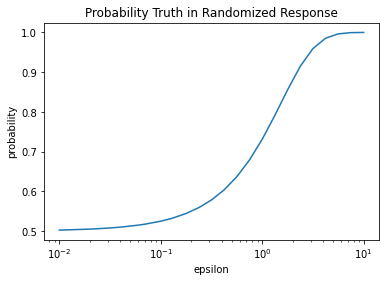

In [3]:

#### Plot Randomized Response Mechanism ####

ep_seq = np.around(np.logspace(start=np.log10(10), stop=np.log10(0.01), num=25), decimals=2)
print("epsilon sequence", ep_seq)

probtrue = np.exp(ep_seq)/(1 + np.exp(ep_seq))

#plot(x=ep.seq, y=probtrue, type="l", log = "x", lwd=2, main="Probability Truth in Randomized Response", xlab="epsilon", ylab="probability")

# import pylab
import matplotlib.pyplot as plt

plt.plot(ep_seq, probtrue)
plt.title("Probability Truth in Randomized Response")
plt.ylabel("probability")
plt.xscale("log")
plt.xlabel("epsilon")
plt.show()


In [2]:
def correction(release, epsilon):
    inflation = (np.exp(epsilon) + 1)/(np.exp(epsilon) - 1)
    expectation = (release * inflation).mean()

    return expectation


def neg_log_likelihood(b, data, epsilon):
    # Transform unconstrained b into 0<p<1
    p = 1 / (1 + np.exp(-b))

    # transform to {0, 1}
    z = (data + 1) // 2

    pfalse = 1 / (1 + np.exp(epsilon))
    ptrue = 1 - pfalse  # Or np.exp(epsilon)/(1-exp(epsilon))

    llik = 1 #Fix This


    return -llik


#### Simulation

Here we are going to sample a dataset and show various release mechanisms.
 

In [4]:
#### Simulation ####

# Parameters
data_size = 1_000
epsilon = 0.5

# Simulate dataset
data = np.random.binomial(n=1, p=0.3, size=data_size)
data[data == 0] = -1
true = data.mean()

# Release each observation by RR
release = local_release(data, epsilon)

# Correct expectation by inflation
expectation = correction(release=release, epsilon=epsilon)


def minimize_maxlik_mean(data, release, epsilon):
    from scipy.optimize import minimize_scalar

    output = minimize_scalar(neg_log_likelihood, args=(release, epsilon))
    maxlik_p = 1 / (1 + np.exp(-output.x))
    return maxlik_p * np.max(data) + (1 - maxlik_p) * np.min(data)

# Correct expectation by Max.Likelihood
maxlik_mean = minimize_maxlik_mean(data, release, epsilon)

print("Mean of data:       ", np.mean(data))
print("Mean of DP release: ", np.mean(release))
print("Mean corrected:     ", expectation)
print("MaxLikelihood mean: ", maxlik_mean)

Mean of data:        -0.436
Mean of DP release:  -0.088
Mean corrected:      -0.3593029585264764
MaxLikelihood mean:  -0.3593029774496194


#### Show loglikelihood surface

Maximizing the loglikelihood surface (or in the Bayesian context, the posterior surface) is a general approach to correcting DP releases for any bias in parameters introduced by noise addition or other DP mechanisms.

The Wald test shown below, shows a region that can not be rejected as the underlying parameters that the dataset was drawn from.

In [5]:
#### Show loglikelihood surface ####

# These are the probabilities we want to find the llikelihood of
p_seq = np.linspace(start=0.01, stop=0.99, num=99)  
# These are the inverse transformations
b_seq = -np.log(p_seq**(-1) - 1)             

# print(p_seq)
# print(b_seq)

all_llik = []
	
for b in b_seq:
    llik = -neg_log_likelihood(b=b, data=release, epsilon=epsilon)
    all_llik.append(llik)


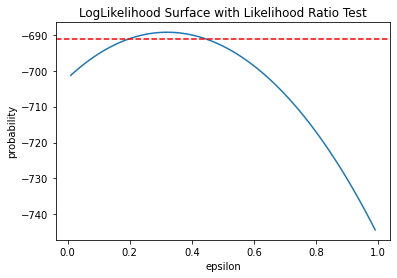

In [6]:
from scipy.stats import chi2

test_statistic=max(all_llik) - chi2.ppf(q=0.95, df=1)/2

plt.plot(p_seq, all_llik)
plt.title("LogLikelihood Surface with Likelihood Ratio Test")
plt.ylabel("probability")
plt.xlabel("epsilon")
plt.axhline(test_statistic, color="red", linestyle='--')
plt.show()


#### Show utility over sample size

Here we show Root Mean Squared Error as a function of sample size, compared to what is possible in the centralized model with the Laplace mechanism, as well as compared to sampling error between the true sensitive sample value and the underlying population parameter.


In [7]:
#### Simulate many times #####
from mock_dp_library import release_dp_mean
import pandas as pd
data_size = 5_000
epsilon = 0.5

data = np.random.binomial(n=1, p=0.3, size=data_size)
data[data==0] = -1
true_value = data.mean()



nsims = 500
history = []

for j in range(nsims):
    release = local_release(data, epsilon)

    history.append([
        # mean of dp release
        release.mean(),

        # corrected mean dp release
        correction(release=release, epsilon=epsilon),

        # maximum likelihood mean
        minimize_maxlik_mean(data, release, epsilon),
        
        # laplace release
        release_dp_mean(x=data, bounds=[-1,1], epsilon=epsilon)
    ])
    
columns = ["release_mean", "corrected_mean", "ml_mean", "laplace_mean"]
history = pd.DataFrame(history, columns=columns)

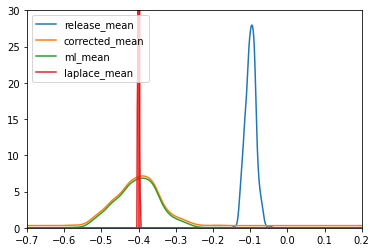

In [8]:
from scipy import stats

lower, upper = history.to_numpy().min(), history.to_numpy().max()

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

def density(x):
    kernel = stats.gaussian_kde(x)
    support = np.linspace(lower - kernel.factor, upper + kernel.factor, num=1000)
    return support, kernel(support)

for column in columns:
    dens = density(history[column])

    # corrected mean is right on top of ml_mean
    if column == "corrected_mean":
        dens = (dens[0], dens[1] + .3)
        
    plt.plot(*dens, label=column)

plt.ylim(0, 30)
plt.xlim(-0.7, 0.2)
plt.legend()
plt.axvline(true_value, color="red")




In [9]:
#### Show utility over sample size ####

n_seq = np.logspace(start=np.log10(200), stop=np.log10(5000), num=15).astype(int)
print("N sequence      ", n_seq)

epsilon = 0.5
mypi = 0.3
population_true = mypi*1 + (1-mypi)*(-1)

nsims = 1000
history = [] 

for i in n_seq:
    error_local = []
    error_laplace = []
    error_sampling = []
    for j in range(nsims):
        data = np.random.binomial(n=1, p=0.3, size=i)
        data[data==0] = -1
    
        true = data.mean()
        ldp_release = local_release(data, epsilon)
        
        laplace_release = release_dp_mean(x=data, bounds=[-1,1], epsilon=epsilon)
                    #np.random.laplace(np.clip(data, -1, 1).mean(), 2 / epsilon)

        error_local.append((true - correction(release=ldp_release, epsilon=epsilon))**2)
        error_laplace.append((true - laplace_release)**2)
        error_sampling.append((true - population_true)**2)

    history.append([
        # Sample size
        i,

        # RMSE in the Local Model
        np.sqrt(np.mean(error_local)),

        # RMSE in the Central Model
        np.sqrt(np.mean(error_laplace)),

        # Sampling Error
        np.sqrt(np.mean(error_sampling)),
    ])
columns = ["sample_size", "local_rmse", "central_rmse", "sampling_error"]
history = pd.DataFrame(history, columns = columns)

N sequence       [ 200  251  316  398  501  631  794 1000 1258 1583 1993 2508 3156 3972
 4999]


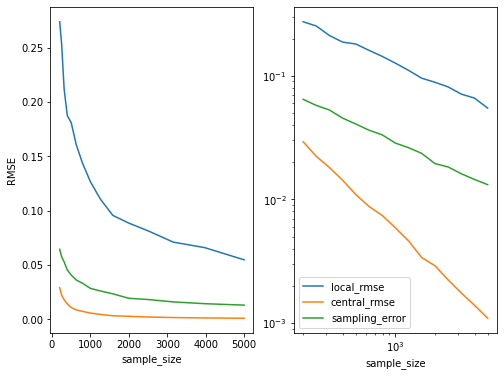

In [10]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(8,6))

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[1].set_xscale("log")


for column in columns[1:]:
    for ax in axs:
        history.plot(x="sample_size", y=column, ax=ax, legend=None)

plt.legend()

#### Local DP for Integers or Histograms

There are many expansions we can explore with the building block of RR in the local model.  One we have already considered is to generate a histogram of categorical outcomes (or create a LDP mechanism for integers).


In [1]:
from mock_dp_library import *


import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1, 16)  # easily guessable without looking at the data

educ = data['educ'].values.astype(int)


## Differentially private histogram for integers

def local_histogram_release(x, bounds, epsilon):
    lower, upper = bounds
    bins = list(range(lower, upper + 1))

    x_clamped = clamp(x, bounds)
    sensitivity = 2

    sensitive_value = []
    dp_release = np.zeros((len(x), upper - lower + 1))

    for i in range(len(x)):
        current_x = x_clamped[i] 

        for j in range(len(bins)):
            sensitive_value = (current_x == bins[j]) * 2 - 1
            dp_release[i, j] = local_release(sensitive_value, epsilon=epsilon/sensitivity) 

    # fast way! one-hot encode by indexing into an identity matrix
    # one_hot = np.eye(upper - lower + 1, dtype=int)[x - lower] * 2 - 1
    # return local_release(one_hot, epsilon / sensitivity)
    
    return dp_release

nboot = 2_000
boot_data = bootstrap(educ, n=nboot)



## Release Local DP Histogram ##

my_epsilon = 1

dp_hist = local_histogram_release(x=boot_data, bounds=educ_bounds, epsilon=my_epsilon) 


raw_dp_values = dp_hist.mean(axis=0) 
c = 1 #Fix This
corrected = c * raw_dp_values 

true_values = np.unique(educ, return_counts=True)[1] / len(educ)

#print("raw ", raw_dp_values)
#print("dp  ", dp_values)
#print("true", true_values)

pd.DataFrame({
    "true_values": true_values, 
    "raw_dp_values": (raw_dp_values + 1) / 2, 
    "corrected_dp_values": (corrected + 1) / 2
}).plot(kind="bar")

print(c)


NameError: name 'local_release' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>